<a href="https://colab.research.google.com/github/tvle2/GKP_sens/blob/main/Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qutip
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Total run time:   0.98s
[array([0.55888761, 0.58722635])]
[array([0, 1])]


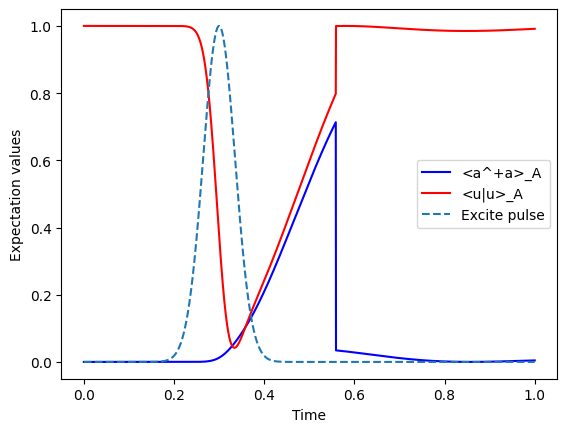

In [ ]:
Na = 3 # number of atomic levels
ustate = basis(Na, 0)
excited = basis(Na, 1)
ground = basis(Na, 2)

N = 10 # Set where to truncate Fock state for cavity
sigma_A_ge = tensor(qeye(N), ground * excited.dag(), qeye(N), qeye(Na)) # |g><e| of mode A
sigma_A_ue = tensor(qeye(N), ustate * excited.dag(), qeye(N), qeye(Na)) # |u><e| of mode A
sigma_B_ge = tensor(qeye(N), qeye(Na), qeye(N), ground * excited.dag()) # |g><e| of mode B
sigma_B_ue = tensor(qeye(N), qeye(Na), qeye(N), ustate * excited.dag()) # |u><e| of mode B

a_A = tensor(destroy(N), qeye(Na), qeye(N),qeye(Na)) # annihiliation occurs at mode A not B
a_B = tensor(qeye(N), qeye(Na), destroy(N), qeye(Na)) # annihiliation occurs at mode B not A

### Let's define collapse operators
c_ops = [] # Build collapse operators

kappa = 5 # Cavity decay rate
c_ops.append(np.sqrt(kappa) * a_A) # Cavity decay at mode A    C0
c_ops.append(np.sqrt(kappa) * a_B) # Cavity decay at mode B    C1

gamma = 0.4 # Atomic decay rate
c_ops.append(np.sqrt(5*gamma/9) * sigma_A_ue) # Use Rb branching ratio of 5/9 e->u at mode A     C2
c_ops.append(np.sqrt(4*gamma/9) * sigma_A_ge) # 4/9 e->g at mode A                               C3
c_ops.append(np.sqrt(5*gamma/9) * sigma_B_ue) # Use Rb branching ratio of 5/9 e->u at mode B     C4
c_ops.append(np.sqrt(4*gamma/9) * sigma_B_ge) # 4/9 e->g at mode B                               C5

# kappa_prop = 0.1 # Propagation loss after the cavity
# c_ops.append(np.sqrt(kappa_prop) * a_A) # propagation loss at mode A                             C6
# c_ops.append(np.sqrt(kappa_prop) * a_B) # propagation loss at mode B                             C7


# eta=1 # quantum efficiency
# kappa_det = 10 # Detection
# c_ops.append(np.sqrt(kappa_det*eta)*(a_A+a_B)/np.sqrt(2)) # successfully detected photon at mode A              C8
# c_ops.append(np.sqrt(kappa_det*(1-eta))*(a_A+a_B)/np.sqrt(2)) # non-successfully detected photon at mode A      C9
# c_ops.append(np.sqrt(kappa_det*eta)*(a_A-a_B)/np.sqrt(2)) # successfully detected photon at mode B              C10
# c_ops.append(np.sqrt(kappa_det*(1-eta))*(a_A-a_B)/np.sqrt(2)) # non-successfully detected photon at mode B      C11


e_ops=[a_A.dag()*a_A, sigma_A_ue*sigma_A_ue.dag(), a_B.dag()*a_B, sigma_B_ue*sigma_B_ue.dag()]

t = np.linspace(0.0, 1.0, 2000) # Define time vector
psi0 = tensor(basis(N, 0), ustate, basis(N, 0), ustate) # Define initial state


g = 5 # coupling strength
# H_BS = np.pi/4*1j*(a_A.dag()*a_B-a_B.dag()*a_A)
H0 = -g * (sigma_A_ue.dag() * a_A + a_A.dag() * sigma_A_ue)-g * (sigma_B_ue.dag() * a_B + a_B.dag() * sigma_B_ue)# time-independent term
H1_A = (sigma_A_ue.dag() + sigma_A_ue) # time-dependent term
H1_B = (sigma_B_ue.dag() + sigma_B_ue)

times = t

numb = 1
ntraj = [numb] # list of number of trajectories to avg. over

peak =21
center=0.3
life_time=0.05

excite_pulse = peak * np.exp(-((t-center) / life_time) ** 2)
excite_pulse_nor = excite_pulse/peak

# H = [H0, [H1, '21 * exp(-((t-0.3) / 0.05) ** 2)']]
H = [H0, [H1_A, excite_pulse],[H1_B, excite_pulse]]

output = mcsolve(H, psi0, times, c_ops,e_ops,ntraj)


plt.figure()
print(output.col_times)
print(output.col_which)
plt.plot(times, output.expect[0],'b')
plt.plot(times, output.expect[1],'r')
# plt.plot(times, output.expect[2],'c')
# plt.plot(times, output.expect[3],'m')
plt.plot(times, excite_pulse_nor,'--')


plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.legend(("<a^+a>_A", "<u|u>_A", "Excite pulse"))
plt.show()
